In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
from sbi.analysis import pairplot
from sbi.inference import SNPE
from sbi.utils import BoxUniform, posterior_nn
from torch import ones, zeros
import pickle

from sbi.analysis import conditional_pairplot
import pickle
import sbi
from sbi.analysis import conditional_corrcoeff
from sbi.analysis import eval_conditional_density

sys.path.append("../../../arco_sims/adaptive_box_posteriors/")
import bounds

In [3]:
import time

In [4]:
params_name_mapping = {
'ephys.NaTa_t.soma.gNaTa_tbar':'s.Na_t',
'ephys.Nap_Et2.soma.gNap_Et2bar':'s.Na_p',
'ephys.K_Pst.soma.gK_Pstbar':'s.K_p',
'ephys.K_Tst.soma.gK_Tstbar':'s.K_t',
'ephys.SK_E2.soma.gSK_E2bar':'s.SK',
'ephys.SKv3_1.soma.gSKv3_1bar':'s.Kv_3.1',
'ephys.Ca_HVA.soma.gCa_HVAbar':'s.Ca_H',
'ephys.Ca_LVAst.soma.gCa_LVAstbar':'s.Ca_L',
'ephys.CaDynamics_E2.soma.gamma':'s.Y',
'ephys.CaDynamics_E2.soma.decay':'s.T_decay',
 
'ephys.none.soma.g_pas':'s.leak',
'ephys.none.axon.g_pas':'ax.leak',
'ephys.none.dend.g_pas':'b.leak',
'ephys.none.apic.g_pas':'a.leak',
 
'ephys.NaTa_t.axon.gNaTa_tbar':'ax.Na_t',
'ephys.Nap_Et2.axon.gNap_Et2bar':'ax.Na_p',
'ephys.K_Pst.axon.gK_Pstbar':'ax.K_p',
'ephys.K_Tst.axon.gK_Tstbar':'ax.K_t',
'ephys.SK_E2.axon.gSK_E2bar':'ax.SK',
'ephys.SKv3_1.axon.gSKv3_1bar':'ax.Kv_3.1',
'ephys.Ca_HVA.axon.gCa_HVAbar':'ax.Ca_H',
'ephys.Ca_LVAst.axon.gCa_LVAstbar':'ax.Ca_L',
'ephys.CaDynamics_E2.axon.gamma':'ax.Y',
'ephys.CaDynamics_E2.axon.decay':'ax.T_decay',
 
'ephys.Im.apic.gImbar':'a.I_m',
'ephys.NaTa_t.apic.gNaTa_tbar':'a.Na_t',
'ephys.SKv3_1.apic.gSKv3_1bar':'a.Kv_3.1',
'ephys.Ca_HVA.apic.gCa_HVAbar':'a.Ca_H',
'ephys.Ca_LVAst.apic.gCa_LVAstbar':'a.Ca_L',
'ephys.SK_E2.apic.gSK_E2bar':'a.SK',
'ephys.CaDynamics_E2.apic.gamma':'a.Y',
'ephys.CaDynamics_E2.apic.decay':'a.T_decay',
 
'ephys.SKv3_1.apic.offset':'a.Kv_3.1_offset',
'ephys.SKv3_1.apic.slope':'a.Kv_3.1_slope',
'scale_apical.scale': 'a.scale'
}

In [5]:
dataset = np.load(
    "../../../arco_sims/adaptive_box_posteriors/simulation_outputs/theta_and_x.npz",
    allow_pickle=True,
)
theta = dataset["theta"].tolist()
x = dataset["x"].tolist()

In [6]:
xo = torch.tensor([3.1, 3.1, 3.1, 3.1, 3.1, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5])

In [7]:
filepath = "/home/michael/Documents/arco_sims/adaptive_box_posteriors2/88_86940691440007411_0.01.pickle"

with open(filepath, "rb") as handle:
    posterior2 = pickle.load(handle)

In [8]:
samples = posterior2.sample((10000,), x=xo)

# Analyse all morphologies and configurations

In [9]:
names_ = list(params_name_mapping.values())

In [10]:
string_pairs = [
    ["84", "7712997831240842", "0.015"],
    ["85", "1", "0.02"],
    ["85", "5", "0.015"],
    ["86", "6", "0.005"],
    ["86", "707527054352652", "0.01"],
    ["87", "550434680389613", "0.005"],
    ["87", "73418029210004229", "0.005"],
    ["88", "59997244694401254", "0.015"],
    ["88", "86940691440007411", "0.01"],
    ["88", "90233447606250669", "0.005"],
    ["89", "1506562604769867", "0.02"],
    ["89", "49992413252944133", "0.02"],
    ["89", "98394633867104423", "0.025"],
    ["91", "5", "0.03"],
    ["91", "63065090307991878", "0.045"],
    ["93", "49588549670578687", "0.01"],
    ["WR64_Cell8_L5TT_constant_mean_max_dendscale_2.0", "94", "0.01"],
    ["WR64_Cell8_L5TT_constant_mean_max_dendscale_2.0", "96", "0.01"],
    ["WR64_Cell8_L5TT_constant_mean_max_dendscale_2.5", "81", "0.015"],
    ["WR64_Cell8_L5TT_constant_mean_max_dendscale_2.5", "84", "0.03"],
    ["WR69_Cell2_L5TT_mean", "1", "0.005"],
    ["WR69_Cell2_L5TT_mean", "32", "0.01"],
    ["WR69_Cell2_L5TT_medfilt", "1", "0.005"],
    ["WR69_Cell2_L5TT_medfilt", "6", "0.01"],
    ["WR71_Cell6_L5TT_constant_mean", "104", "0.02"],
    ["WR71_Cell6_L5TT_constant_mean", "120", "0.015"],
    ["WR71_Cell6_L5TT_constant_mean_exclude_obliques_from_hot_zone", "130", "0.015"],
    ["WR71_Cell6_L5TT_constant_mean_exclude_obliques_from_hot_zone", "136", "0.01"]
]

### Save samples

In [53]:
def save_samples(str1, str2, str3):

    torch.manual_seed(0)
    filepath = f"/home/michael/Documents/arco_sims/adaptive_box_posteriors2/{str1}_{str2}_{str3}.pickle"

    with open(filepath, "rb") as handle:
        posterior = pickle.load(handle)

    all_bounds_ = bounds.bounds_
    bounds_ = all_bounds_[str1, str2]
    upper_ = np.asarray(list(bounds_["max"].values()))
    lower_ = np.asarray(list(bounds_["min"].values()))
    gt_ = np.asarray(list(bounds_["value"].values()))
    limits = np.asarray([lower_, upper_]).T

    condition = torch.as_tensor(gt_, dtype=torch.float32)
    posterior.set_default_x(xo)

    samples = posterior.sample((35_000,))
    samples_np = samples.numpy()
    np.save(f"Samples_from_each_posterior_support/Samples_{str1}_{str2}_{str3}.npy", samples_np)

In [54]:
for s in string_pairs:
    print("s", s)
    save_samples(*s)

s ['84', '7712997831240842', '0.015']



s ['85', '1', '0.02']



s ['85', '5', '0.015']



s ['86', '6', '0.005']



s ['86', '707527054352652', '0.01']



s ['87', '550434680389613', '0.005']



s ['87', '73418029210004229', '0.005']



s ['88', '59997244694401254', '0.015']



s ['88', '86940691440007411', '0.01']



s ['88', '90233447606250669', '0.005']



s ['89', '1506562604769867', '0.02']



s ['89', '49992413252944133', '0.02']



s ['89', '98394633867104423', '0.025']



s ['91', '5', '0.03']



s ['91', '63065090307991878', '0.045']



s ['93', '49588549670578687', '0.01']



s ['WR64_Cell8_L5TT_constant_mean_max_dendscale_2.0', '94', '0.01']



s ['WR64_Cell8_L5TT_constant_mean_max_dendscale_2.0', '96', '0.01']



s ['WR64_Cell8_L5TT_constant_mean_max_dendscale_2.5', '81', '0.015']



s ['WR64_Cell8_L5TT_constant_mean_max_dendscale_2.5', '84', '0.03']



s ['WR69_Cell2_L5TT_mean', '1', '0.005']



s ['WR69_Cell2_L5TT_mean', '32', '0.01']



s ['WR69_Cell2_L5TT_medfilt', '1', '0.005']



s ['WR69_Cell2_L5TT_medfilt', '6', '0.01']



s ['WR71_Cell6_L5TT_constant_mean', '104', '0.02']



s ['WR71_Cell6_L5TT_constant_mean', '120', '0.015']



s ['WR71_Cell6_L5TT_constant_mean_exclude_obliques_from_hot_zone', '130', '0.015']



s ['WR71_Cell6_L5TT_constant_mean_exclude_obliques_from_hot_zone', '136', '0.01']


### Save samples from support

In [36]:
class PosteriorSupport:
    def __init__(self, posterior, prior, num_samples_to_estimate_support: int = 50_000, quantile: float = 0.0):
        samples = posterior.sample((num_samples_to_estimate_support,))
        log_probs = posterior.log_prob(samples)
        sorted_log_probs, _ = torch.sort(log_probs)
        print(sorted_log_probs)
        self.thr = sorted_log_probs[int(num_samples_to_estimate_support * quantile)]
        self.thr = torch.min(log_probs)
        print('self.thr', self.thr)

    def sample(self, sample_shape: torch.Size):
        """
        Sample from the posterior support.

        This is done by sampling from the prior and accepting samples only if
        their posterior-log-probability is larger than some threshold. The
        threshold is chosen to be the minimum log-prob of 50_000 posterior
        samples (see `num_samples_to_estimate_support` in `__init__()`).
        """
        all_accepted = []
        num_samples = torch.Size(sample_shape).numel()
        num_remaining = num_samples
        total_drawn = 0
        while num_remaining > 0:
            num_to_draw = torch.max(torch.tensor([num_remaining]), torch.tensor([10_000]))
            prior_samples = prior.sample((num_to_draw,))
            posterior_log_probs = posterior.log_prob(prior_samples)
            accepted_samples = prior_samples[posterior_log_probs > self.thr]
            all_accepted.append(accepted_samples)
            num_remaining -= accepted_samples.shape[0]
            total_drawn += num_to_draw
        print("Accepted", torch.cat(all_accepted).shape[0], 'samples out of', total_drawn, 'candidate samples.')
        frac = torch.as_tensor(torch.cat(all_accepted).shape[0], dtype=torch.float32)/total_drawn
        print("The fraction of accepted samples is: ", frac)
        print("The speed-up is:  ", 1/frac)
        return torch.cat(all_accepted)[:num_samples]

    def log_prob():
        raise NotImplementedError

In [51]:
def save_support_samples(str1, str2, str3):
    _ = torch.manual_seed(0)

    filepath = f"/home/michael/Documents/arco_sims/adaptive_box_posteriors2/{str1}_{str2}_{str3}.pickle"

    with open(filepath, "rb") as handle:
        posterior = pickle.load(handle)

    all_bounds_ = bounds.bounds_
    bounds_ = all_bounds_[str1, str2]
    upper_ = np.asarray(list(bounds_["max"].values()))
    lower_ = np.asarray(list(bounds_["min"].values()))
    gt_ = np.asarray(list(bounds_["value"].values()))
    limits = np.asarray([lower_, upper_]).T
    prior = BoxUniform(torch.as_tensor(lower_, dtype=torch.float32), torch.as_tensor(upper_, dtype=torch.float32))

    condition = torch.as_tensor(gt_, dtype=torch.float32)
    posterior.set_default_x(xo)

    p_support = PosteriorSupport(posterior, prior, num_samples_to_estimate_support=50_000, quantile=0.0)
    support_samples = p_support.sample((35_0,))
    np.save(f"Samples_from_each_posterior_support/Samples_{str1}_{str2}_{str3}.npy", support_samples.numpy())

In [52]:
for s in string_pairs:
    print("s", s)
    save_support_samples(*s)

s ['84', '7712997831240842', '0.015']



tensor([204.9622, 205.5645, 205.6768,  ..., 223.8219, 224.1922, 225.0183])
self.thr tensor(204.9622)
Accepted 396 samples out of tensor([20000]) candidate samples.
The fraction of accepted samples is:  tensor([0.0198])
The speed-up is:   tensor([50.5051])
s ['85', '1', '0.02']



tensor([196.2405, 196.4562, 196.7590,  ..., 213.2295, 213.4021, 213.7919])
self.thr tensor(196.2405)
Accepted 506 samples out of tensor([10000]) candidate samples.
The fraction of accepted samples is:  tensor([0.0506])
The speed-up is:   tensor([19.7628])
s ['85', '5', '0.015']



tensor([209.0305, 209.3715, 209.4881,  ..., 227.7470, 228.0164, 228.0798])
self.thr tensor(209.0305)
Accepted 362 samples out of tensor([290000]) candidate samples.
The fraction of accepted samples is:  tensor([0.0012])
The speed-up is:   tensor([801.1050])
s ['86', '6', '0.005']



tensor([239.5855, 240.6075, 243.5180,  ..., 259.9283, 260.1462, 260.4124])
self.thr tensor(239.5855)


KeyboardInterrupt: 

In [43]:
filepath = f"/home/michael/Documents/arco_sims/adaptive_box_posteriors2/85_1_0.02.pickle"

with open(filepath, "rb") as handle:
    posterior = pickle.load(handle)

all_bounds_ = bounds.bounds_
bounds_ = all_bounds_["85", "1"]
upper_ = np.asarray(list(bounds_["max"].values()))
lower_ = np.asarray(list(bounds_["min"].values()))
gt_ = np.asarray(list(bounds_["value"].values()))
limits = np.asarray([lower_, upper_]).T
prior = BoxUniform(torch.as_tensor(lower_, dtype=torch.float32), torch.as_tensor(upper_, dtype=torch.float32))

condition = torch.as_tensor(gt_, dtype=torch.float32)
posterior.set_default_x(xo)

samples = posterior.sample((1000,))
p_support = PosteriorSupport(posterior, prior, num_samples_to_estimate_support=50_000, quantile=0.0)
support_samples = p_support.sample((1000,))


tensor([196.4150, 196.6219, 196.6909,  ..., 213.5618, 214.1284, 214.4905])
self.thr tensor(196.4150)
Accepted 1145 samples out of tensor([20000]) candidate samples.
The fraction of accepted samples is:  tensor([0.0573])
The speed-up is:   tensor([17.4672])


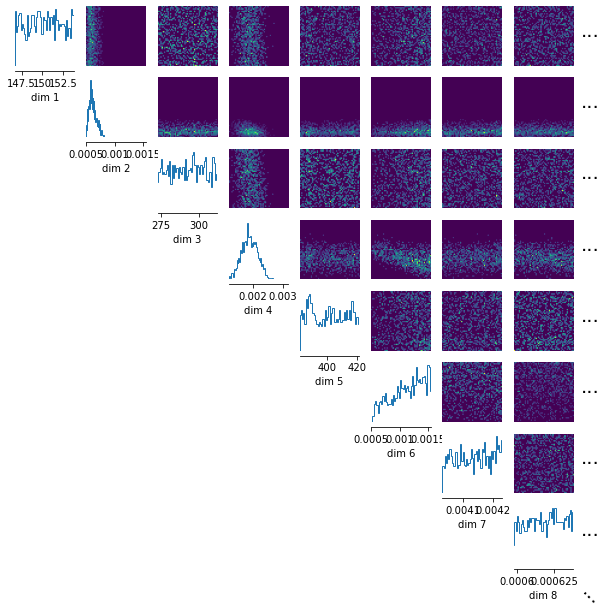

In [40]:
_ = pairplot(samples, subset=[0,1,2,3,4,5,6,7], limits=limits)

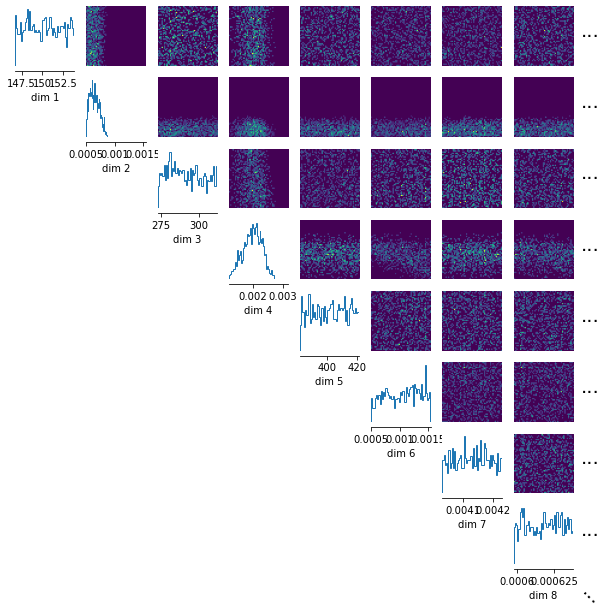

In [27]:
_ = pairplot(support_samples, subset=[0,1,2,3,4,5,6,7], limits=limits)

### Analyse conditional correlations

In [138]:
def obtain_conditional_corrcoeff(str1, str2, str3):

    filepath = f"/home/michael/Documents/arco_sims/adaptive_box_posteriors2/{str1}_{str2}_{str3}.pickle"

    with open(filepath, "rb") as handle:
        posterior = pickle.load(handle)

    all_bounds_ = bounds.bounds_
    bounds_ = all_bounds_[str1, str2]
    upper_ = np.asarray(list(bounds_["max"].values()))
    lower_ = np.asarray(list(bounds_["min"].values()))
    gt_ = np.asarray(list(bounds_["value"].values()))
    limits = np.asarray([lower_, upper_]).T

    condition = torch.as_tensor(gt_, dtype=torch.float32)
    posterior.set_default_x(xo)

    corrcoeff = conditional_corrcoeff(posterior, condition=condition, limits=torch.as_tensor(limits, dtype=torch.float32))
    return corrcoeff

In [139]:
all_corrcoeffs = []

for s in string_pairs:
    print("s", s)
    start_time = time.time()
    corrcoeff_ = obtain_conditional_corrcoeff(*s)
    all_corrcoeffs.append(corrcoeff_.numpy())

all_corrcoeffs = np.asarray(all_corrcoeffs)
# np.save("all_corrcoeffs.npy", all_corrcoeffs)

s ['84', '7712997831240842', '0.015']
s ['85', '1', '0.02']
s ['85', '5', '0.015']
s ['86', '6', '0.005']
s ['86', '707527054352652', '0.01']
s ['87', '550434680389613', '0.005']
s ['87', '73418029210004229', '0.005']
s ['88', '59997244694401254', '0.015']
s ['88', '86940691440007411', '0.01']
s ['88', '90233447606250669', '0.005']
s ['89', '1506562604769867', '0.02']
s ['89', '49992413252944133', '0.02']
s ['89', '98394633867104423', '0.025']
s ['91', '5', '0.03']
s ['91', '63065090307991878', '0.045']
s ['93', '49588549670578687', '0.01']
s ['WR64_Cell8_L5TT_constant_mean_max_dendscale_2.0', '94', '0.01']
s ['WR64_Cell8_L5TT_constant_mean_max_dendscale_2.0', '96', '0.01']
s ['WR64_Cell8_L5TT_constant_mean_max_dendscale_2.5', '81', '0.015']
s ['WR64_Cell8_L5TT_constant_mean_max_dendscale_2.5', '84', '0.03']
s ['WR69_Cell2_L5TT_mean', '1', '0.005']
s ['WR69_Cell2_L5TT_mean', '32', '0.01']
s ['WR69_Cell2_L5TT_medfilt', '1', '0.005']
s ['WR69_Cell2_L5TT_medfilt', '6', '0.01']
s ['WR71_Ce

In [142]:
all_corrcoeffs_ = np.load("all_corrcoeffs.npy")

### Plot average matrix

In [143]:
mean_coeffs = np.mean(all_corrcoeffs_, axis=0)

<ipython-input-295-1577c8e7f59a>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(names_, rotation=90)


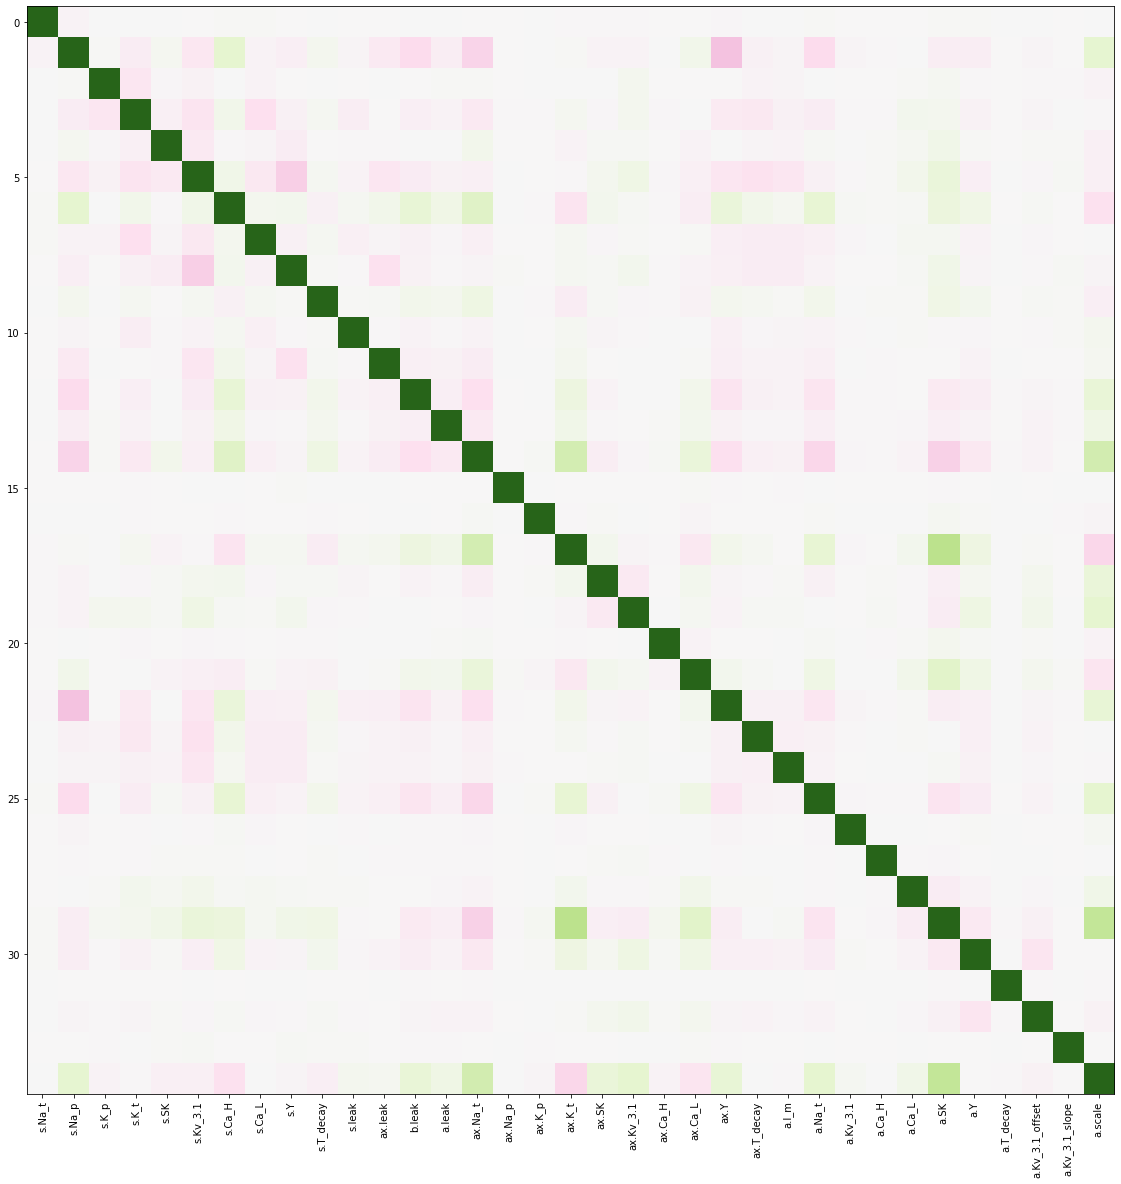

In [295]:
fig, ax = plt.subplots(1, 1, figsize=(20,20))
_ = ax.imshow(mean_coeffs, clim=[-1, 1], cmap='PiYG')
_ = ax.set_xticklabels(names_, rotation=90)
ax.set_xticks(range(35))
plt.savefig("average_condcoeff.png", dpi=200, bbox_inches="tight", facecolor='w')

### Search for the ones with the highest mean

In [155]:
cutoff = 0.25

In [156]:
mean_coeffs_no_diag = np.triu(mean_coeffs, 1)
max_inds = np.abs(mean_coeffs_no_diag) > cutoff
print("Numer of fulfilled: ", np.sum(max_inds))

Numer of fulfilled:  8


In [158]:
num_dims = 35
all_strong_coeffs = []
all_strong_names = []
for col in range(num_dims):
    for row in range(num_dims):
        if max_inds[col, row]:
            strong_coeffs = all_corrcoeffs_[:, col, row]
            strong_cor_names = [names_[col], names_[row]]
            all_strong_coeffs.append(strong_coeffs)
            all_strong_names.append(strong_cor_names)

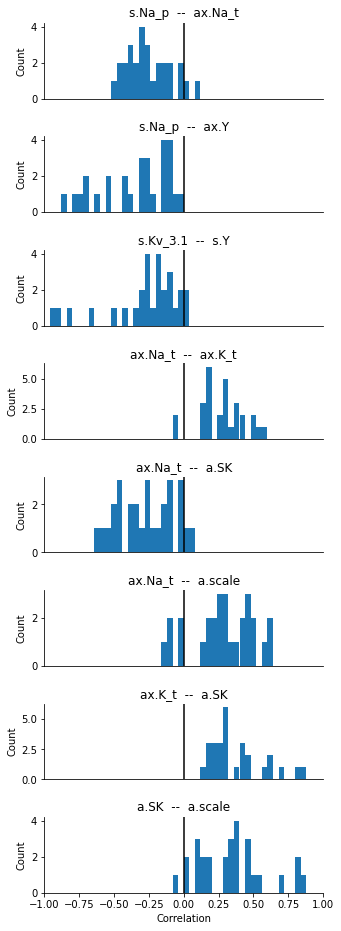

In [294]:
fig, ax = plt.subplots(len(all_strong_coeffs), 1, figsize=(5, 2*len(all_strong_coeffs)))
i = 0
for c, n in zip(all_strong_coeffs, all_strong_names):
    ax[i].hist(c, range=(-1.0, 1.0), bins=50)
    ax[i].set_title(n[0]+"  --  "+n[1])
    ax[i].set_ylabel("Count")
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].set_xlim([-1.0, 1.0])
    ax[i].axvline(0.0, c='k')
    if i < len(all_strong_coeffs) -1:
        ax[i].set_xticks([])
    else:
        ax[i].set_xlabel("Correlation")
    i += 1
plt.subplots_adjust(hspace=0.5)
plt.savefig("maintained_correlations.png", dpi=200, bbox_inches="tight", facecolor='w')
plt.show()

start_time 50.55253195762634


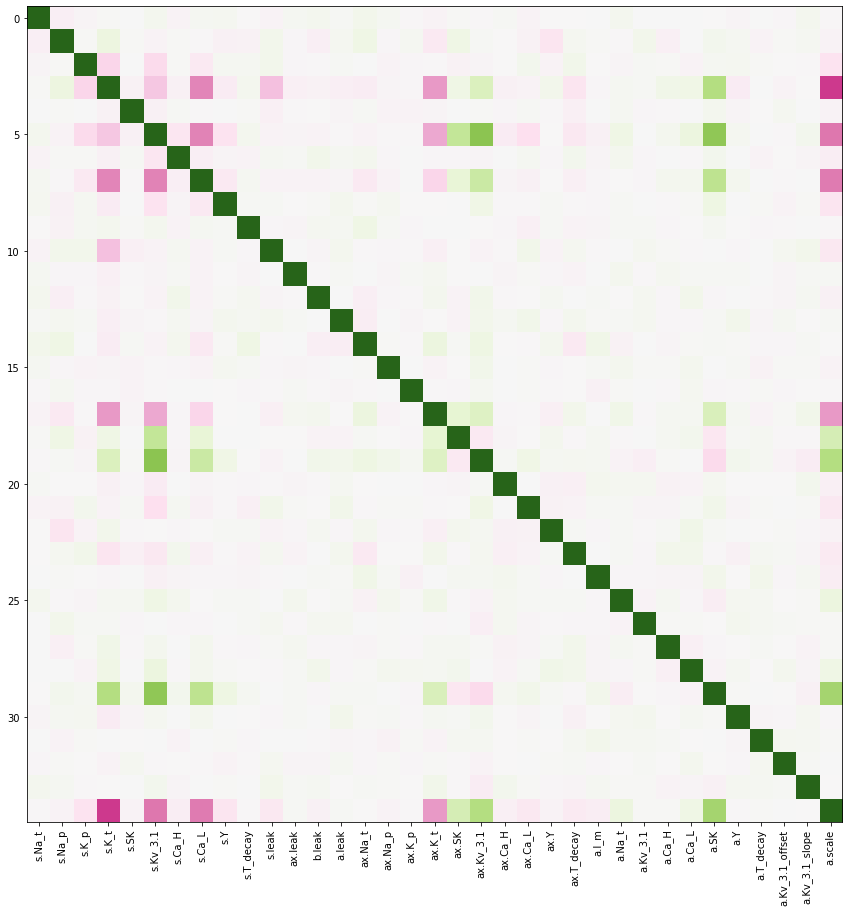

In [41]:
start_time = time.time()
corrcoeff_ = obtain_conditional_corrcoeff("88", "86940691440007411", "0.01")
print("start_time", time.time()-start_time)

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
_ = ax.imshow(corrcoeff_, clim=[-1, 1], cmap='PiYG')
_ = ax.set_xticks(range(35))
_ = ax.set_xticklabels(names_, rotation=90)

### Visualize the 2d conditionals of the 28 morphologies for the parameter pairs (ax.Na_t -- a.SK), (ax.Na_t -- a.scale), (ax.K_t -- a.SK)

In [389]:
parameter_pairs = [("ax.Na_t", "a.SK"), ("ax.Na_t", "a.scale"), ("ax.K_t", "a.SK")]

In [390]:
def get_conditional_2d_plots(str1, str2, str3):

    filepath = f"/home/michael/Documents/arco_sims/adaptive_box_posteriors2/{str1}_{str2}_{str3}.pickle"

    with open(filepath, "rb") as handle:
        posterior = pickle.load(handle)

    all_bounds_ = bounds.bounds_
    bounds_ = all_bounds_[str1, str2]
    upper_ = np.asarray(list(bounds_["max"].values()))
    lower_ = np.asarray(list(bounds_["min"].values()))
    gt_ = np.asarray(list(bounds_["value"].values()))
    limits = np.asarray([lower_, upper_]).T

    condition = torch.as_tensor(gt_, dtype=torch.float32)
    posterior.set_default_x(xo)

    limits_diffs = limits[:, 1] - limits[:, 0]
    eps_margins = limits_diffs / 1e5

    matrices = []
    for param_pair in parameter_pairs:
        ind1 = names_.index(param_pair[0])
        ind2 = names_.index(param_pair[1])

        p_vector = eval_conditional_density(
            posterior,
            condition,
            limits,
            ind1,
            ind2,
            resolution=50,
            eps_margins1=eps_margins[row],
            eps_margins2=eps_margins[col],
            return_raw_log_prob=False
        )
        matrices.append(p_vector.numpy())

    return np.asarray(matrices)

In [391]:
all_2d_plots = []

for s in string_pairs:
    print("s", s)
    start_time = time.time()
    plots_2d = get_conditional_2d_plots(*s)
    all_2d_plots.append(plots_2d)

all_2d_plots = np.asarray(all_2d_plots)
# np.save("all_corrcoeffs.npy", all_corrcoeffs)

s ['84', '7712997831240842', '0.015']
s ['85', '1', '0.02']
s ['85', '5', '0.015']
s ['86', '6', '0.005']
s ['86', '707527054352652', '0.01']
s ['87', '550434680389613', '0.005']
s ['87', '73418029210004229', '0.005']
s ['88', '59997244694401254', '0.015']
s ['88', '86940691440007411', '0.01']
s ['88', '90233447606250669', '0.005']
s ['89', '1506562604769867', '0.02']
s ['89', '49992413252944133', '0.02']
s ['89', '98394633867104423', '0.025']
s ['91', '5', '0.03']
s ['91', '63065090307991878', '0.045']
s ['93', '49588549670578687', '0.01']
s ['WR64_Cell8_L5TT_constant_mean_max_dendscale_2.0', '94', '0.01']
s ['WR64_Cell8_L5TT_constant_mean_max_dendscale_2.0', '96', '0.01']
s ['WR64_Cell8_L5TT_constant_mean_max_dendscale_2.5', '81', '0.015']
s ['WR64_Cell8_L5TT_constant_mean_max_dendscale_2.5', '84', '0.03']
s ['WR69_Cell2_L5TT_mean', '1', '0.005']
s ['WR69_Cell2_L5TT_mean', '32', '0.01']
s ['WR69_Cell2_L5TT_medfilt', '1', '0.005']
s ['WR69_Cell2_L5TT_medfilt', '6', '0.01']
s ['WR71_Ce

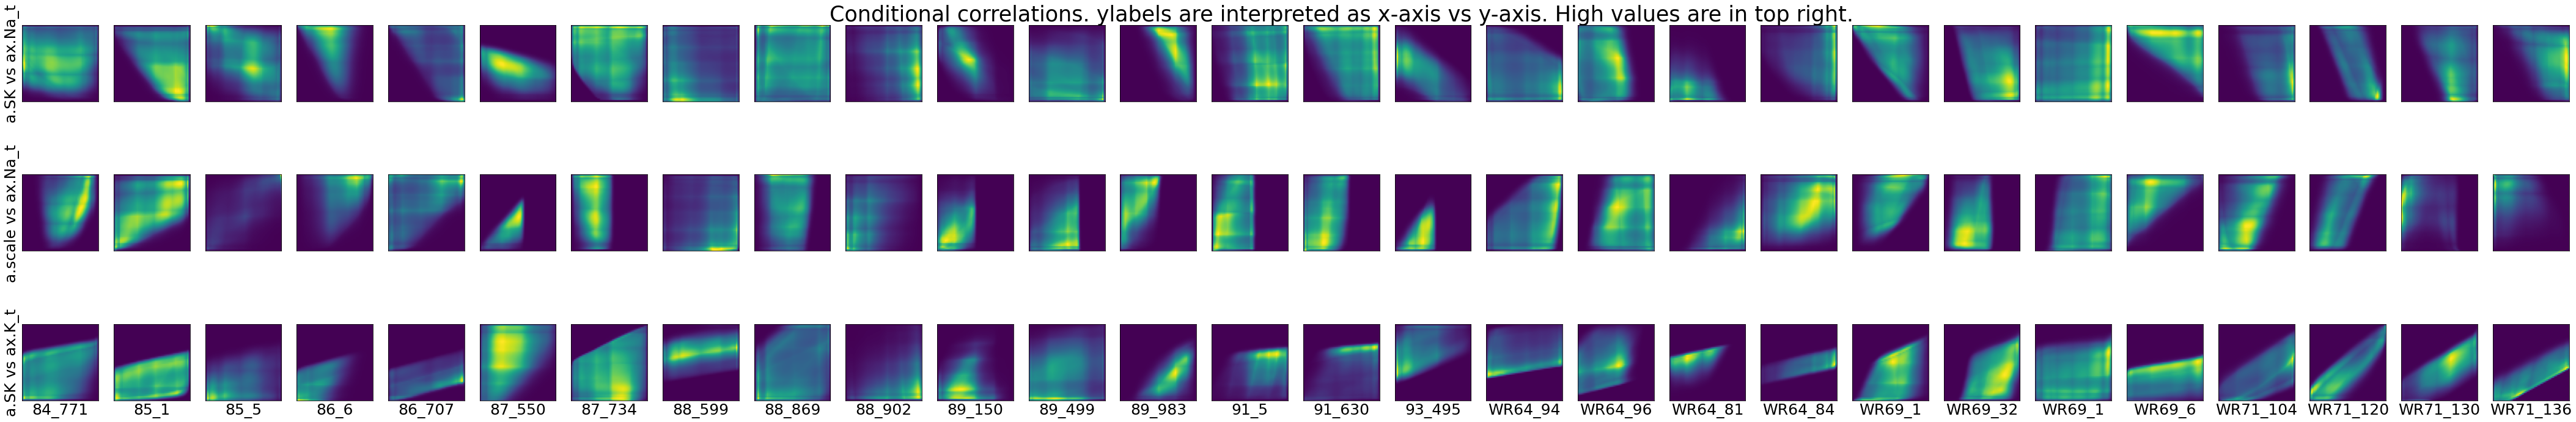

In [416]:
num_morphs = 28
fig, ax = plt.subplots(len(parameter_pairs), num_morphs, figsize=(num_morphs/3*8, 12/3*len(parameter_pairs)))
for i in range(num_morphs):
    for j in range(len(parameter_pairs)):
            ax[j,i].imshow(np.flipud(all_2d_plots[i,j].T))
            ax[j,i].set_xticks([])
            ax[j,i].set_yticks([])
    ax[2, i].set_xlabel(string_pairs[i][0][:4]+"_"+string_pairs[i][1][:3], fontsize=25)
ax[0, 14].set_title("Conditional correlations. ylabels are interpreted as x-axis vs y-axis. High values are in top right.", fontsize=35)
ax[2,0].set_ylabel("a.SK vs ax.K_t", fontsize=25)
ax[1,0].set_ylabel("a.scale vs ax.Na_t", fontsize=25)
ax[0,0].set_ylabel("a.SK vs ax.Na_t", fontsize=25)
plt.subplots_adjust(hspace=0.5)
plt.savefig("2d_conditionals.png", dpi=200, bbox_inches="tight", facecolor='w')
plt.show()

### Get fraction of filled space for 1D conditional

In [132]:
def obtain_fraction_1d(str1, str2, str3):

    filepath = f"/home/michael/Documents/arco_sims/adaptive_box_posteriors2/{str1}_{str2}_{str3}.pickle"

    with open(filepath, "rb") as handle:
        posterior = pickle.load(handle)

    all_bounds_ = bounds.bounds_
    bounds_ = all_bounds_[str1, str2]
    upper_ = np.asarray(list(bounds_["max"].values()))
    lower_ = np.asarray(list(bounds_["min"].values()))
    gt_ = np.asarray(list(bounds_["value"].values()))
    limits = np.asarray([lower_, upper_]).T

    condition = torch.as_tensor(gt_, dtype=torch.float32)
    posterior.set_default_x(xo)

    limits_diffs = limits[:, 1] - limits[:, 0]
    eps_margins = limits_diffs / 1e5

    row = 0
    resolution = 50

    all_log_prob_vecs = []
    for row in range(35):
        p_vector = eval_conditional_density(
            posterior,
            condition,
            limits,
            row,
            row,
            resolution=resolution,
            eps_margins1=eps_margins[row],
            eps_margins2=eps_margins[row],
            return_raw_log_prob=True
        )
        all_log_prob_vecs.append(p_vector)
    all_log_prob_vecs = torch.stack(all_log_prob_vecs)

    log_prob_of_condition = posterior.log_prob(condition)

    max_val = log_prob_of_condition
    all_log_prob_vecs_norm = torch.exp(all_log_prob_vecs - max_val)
    scaled_prob_of_condition = torch.exp(log_prob_of_condition - max_val)

    above_thr = all_log_prob_vecs_norm > scaled_prob_of_condition / 20.0
    fractions_1d_cond = torch.sum(above_thr, axis=1) / resolution

    return fractions_1d_cond

In [133]:
all_1d_fractions = []

for s in string_pairs:
    print("s", s)
    start_time = time.time()
    fraction1d_ = obtain_fraction_1d(*s)
    all_1d_fractions.append(fraction1d_.numpy())

all_1d_fractions = np.asarray(all_1d_fractions)
# np.save("all_1d_fractions.npy", all_1d_fractions)

s ['84', '7712997831240842', '0.015']
s ['85', '1', '0.02']
s ['85', '5', '0.015']
s ['86', '6', '0.005']
s ['86', '707527054352652', '0.01']
s ['87', '550434680389613', '0.005']
s ['87', '73418029210004229', '0.005']
s ['88', '59997244694401254', '0.015']
s ['88', '86940691440007411', '0.01']
s ['88', '90233447606250669', '0.005']
s ['89', '1506562604769867', '0.02']
s ['89', '49992413252944133', '0.02']
s ['89', '98394633867104423', '0.025']
s ['91', '5', '0.03']
s ['91', '63065090307991878', '0.045']
s ['93', '49588549670578687', '0.01']
s ['WR64_Cell8_L5TT_constant_mean_max_dendscale_2.0', '94', '0.01']
s ['WR64_Cell8_L5TT_constant_mean_max_dendscale_2.0', '96', '0.01']
s ['WR64_Cell8_L5TT_constant_mean_max_dendscale_2.5', '81', '0.015']
s ['WR64_Cell8_L5TT_constant_mean_max_dendscale_2.5', '84', '0.03']
s ['WR69_Cell2_L5TT_mean', '1', '0.005']
s ['WR69_Cell2_L5TT_mean', '32', '0.01']
s ['WR69_Cell2_L5TT_medfilt', '1', '0.005']
s ['WR69_Cell2_L5TT_medfilt', '6', '0.01']
s ['WR71_Ce

In [166]:
all_1d_fractions = np.load("all_1d_fractions.npy")

### Add a second parameter and see again

In [296]:
def obtain_probs_2d(str1, str2, str3):

    filepath = f"/home/michael/Documents/arco_sims/adaptive_box_posteriors2/{str1}_{str2}_{str3}.pickle"

    with open(filepath, "rb") as handle:
        posterior = pickle.load(handle)

    all_bounds_ = bounds.bounds_
    bounds_ = all_bounds_[str1, str2]
    upper_ = np.asarray(list(bounds_["max"].values()))
    lower_ = np.asarray(list(bounds_["min"].values()))
    gt_ = np.asarray(list(bounds_["value"].values()))
    limits = np.asarray([lower_, upper_]).T

    condition = torch.as_tensor(gt_, dtype=torch.float32)
    posterior.set_default_x(xo)

    limits_diffs = limits[:, 1] - limits[:, 0]
    eps_margins = limits_diffs / 1e5

    row = 0
    resolution = 50
    max_dim = 35
    all_images = []
    
    full_mat = np.zeros((max_dim, max_dim, resolution, resolution))

    for col in range(max_dim):
        all_log_prob_vecs = []
        for row in range(max_dim):
            if row != col:
                p_vector = eval_conditional_density(
                    posterior,
                    condition,
                    limits,
                    row,
                    col,
                    resolution=resolution,
                    eps_margins1=eps_margins[row],
                    eps_margins2=eps_margins[col],
                    return_raw_log_prob=True
                )
                full_mat[col, row] = p_vector
#                 all_log_prob_vecs.append(p_vector)
#         all_log_prob_vecs = torch.stack(all_log_prob_vecs)
#         all_images.append(all_log_prob_vecs.numpy())

    return np.asarray(full_mat)

In [297]:
all_2d_probs = []

for s in string_pairs:
    print("s", s)
    start_time = time.time()
    probs_2d_ = obtain_probs_2d(*s)
    all_2d_probs.append(probs_2d_)

all_2d_probs = np.asarray(all_2d_probs)
# np.save("all_2d_probs.npy", all_2d_probs)

s ['84', '7712997831240842', '0.015']
s ['85', '1', '0.02']
s ['85', '5', '0.015']
s ['86', '6', '0.005']
s ['86', '707527054352652', '0.01']
s ['87', '550434680389613', '0.005']
s ['87', '73418029210004229', '0.005']
s ['88', '59997244694401254', '0.015']
s ['88', '86940691440007411', '0.01']
s ['88', '90233447606250669', '0.005']
s ['89', '1506562604769867', '0.02']
s ['89', '49992413252944133', '0.02']
s ['89', '98394633867104423', '0.025']
s ['91', '5', '0.03']
s ['91', '63065090307991878', '0.045']
s ['93', '49588549670578687', '0.01']
s ['WR64_Cell8_L5TT_constant_mean_max_dendscale_2.0', '94', '0.01']
s ['WR64_Cell8_L5TT_constant_mean_max_dendscale_2.0', '96', '0.01']
s ['WR64_Cell8_L5TT_constant_mean_max_dendscale_2.5', '81', '0.015']
s ['WR64_Cell8_L5TT_constant_mean_max_dendscale_2.5', '84', '0.03']
s ['WR69_Cell2_L5TT_mean', '1', '0.005']
s ['WR69_Cell2_L5TT_mean', '32', '0.01']
s ['WR69_Cell2_L5TT_medfilt', '1', '0.005']
s ['WR69_Cell2_L5TT_medfilt', '6', '0.01']
s ['WR71_Ce

In [300]:
def extract_2d_fraction(str1, str2, str3, all_log_prob_vecs):

    filepath = f"/home/michael/Documents/arco_sims/adaptive_box_posteriors2/{str1}_{str2}_{str3}.pickle"

    with open(filepath, "rb") as handle:
        posterior = pickle.load(handle)

    all_bounds_ = bounds.bounds_
    bounds_ = all_bounds_[str1, str2]
    upper_ = np.asarray(list(bounds_["max"].values()))
    lower_ = np.asarray(list(bounds_["min"].values()))
    gt_ = np.asarray(list(bounds_["value"].values()))
    limits = np.asarray([lower_, upper_]).T

    condition = torch.as_tensor(gt_, dtype=torch.float32)
    posterior.set_default_x(xo)

    limits_diffs = limits[:, 1] - limits[:, 0]

    log_prob_of_condition = posterior.log_prob(condition)
    max_val = log_prob_of_condition.numpy()

    all_log_prob_vecs_norm = np.exp(all_log_prob_vecs - max_val)
    scaled_prob_of_condition = 1.0
    above_thr = all_log_prob_vecs_norm > scaled_prob_of_condition / 20.0
    print("above_thr", above_thr.shape)
    any_above_thr_in_col = np.any(above_thr, axis=3)
    fractions_2d_cond = np.mean(any_above_thr_in_col, axis=2)

    return fractions_2d_cond

In [301]:
all_2d_fractions = []
i = 0
for s, probs in zip(string_pairs, all_2d_probs):
    print("s", s)
    start_time = time.time()
    fractions_2d = extract_2d_fraction(*s, probs)
    all_2d_fractions.append(fractions_2d)

all_2d_fractions = np.asarray(all_2d_fractions)
# np.save("all_2d_fractions.npy", all_2d_fractions)

s ['84', '7712997831240842', '0.015']
above_thr (35, 35, 50, 50)
s ['85', '1', '0.02']
above_thr (35, 35, 50, 50)
s ['85', '5', '0.015']
above_thr (35, 35, 50, 50)
s ['86', '6', '0.005']
above_thr (35, 35, 50, 50)
s ['86', '707527054352652', '0.01']
above_thr (35, 35, 50, 50)
s ['87', '550434680389613', '0.005']
above_thr (35, 35, 50, 50)
s ['87', '73418029210004229', '0.005']
above_thr (35, 35, 50, 50)
s ['88', '59997244694401254', '0.015']
above_thr (35, 35, 50, 50)
s ['88', '86940691440007411', '0.01']
above_thr (35, 35, 50, 50)
s ['88', '90233447606250669', '0.005']
above_thr (35, 35, 50, 50)
s ['89', '1506562604769867', '0.02']
above_thr (35, 35, 50, 50)
s ['89', '49992413252944133', '0.02']
above_thr (35, 35, 50, 50)
s ['89', '98394633867104423', '0.025']
above_thr (35, 35, 50, 50)
s ['91', '5', '0.03']
above_thr (35, 35, 50, 50)
s ['91', '63065090307991878', '0.045']
above_thr (35, 35, 50, 50)
s ['93', '49588549670578687', '0.01']
above_thr (35, 35, 50, 50)
s ['WR64_Cell8_L5TT_c

In [17]:
all_2d_fractions = np.load("all_2d_fractions.npy")

In [18]:
all_2d_fractions.shape

(28, 35, 35)

In [19]:
best_compensation_in_config = np.max(all_2d_fractions, axis=2)

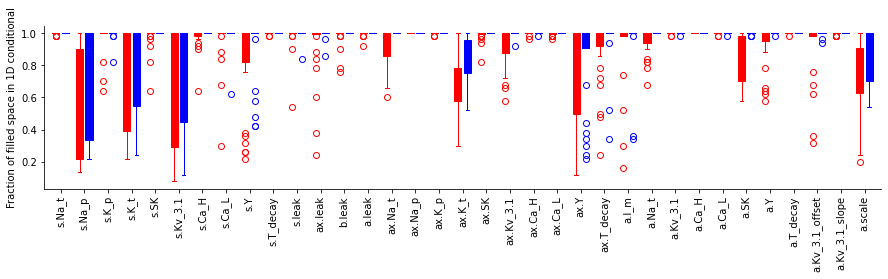

In [419]:
fig, ax = plt.subplots(1,1,figsize=(15,3))
c = 'r'
_ = ax.boxplot(all_1d_fractions, positions=np.arange(0, 35)-0.2, widths=0.3, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
)
c = 'b'
_ = ax.boxplot(best_compensation_in_config, positions=np.arange(0, 35)+0.2, widths=0.3, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xticks(np.arange(0,35))
_ = ax.set_xticklabels(names_, rotation=90)
ax.set_ylabel("Fraction of filled space in 1D conditional")
plt.savefig("fraction_of_filled_space_2d_conditional.png", dpi=200, bbox_inches="tight", facecolor='w')

We want to find a parameter that can, in **any** morphology, compensate perturbations of a specific parameter. Thus, we compute the minimum of the fraction across all 28 posteriors.

In [20]:
min_2d_fraction = np.min(all_2d_fractions, axis=0)

In [21]:
print("")
best_n = 10
best_for_all_morphs = []
for morph in all_2d_fractions:
    best_inds_for_morph = []
    for parameter in morph:
        sorted_inds = np.argsort(parameter)
        best_five_inds = np.flip(sorted_inds[-best_n:])
        best_inds_for_morph.append(best_five_inds)
    best_for_all_morphs.append(best_inds_for_morph)
best_for_all_morphs = np.asarray(best_for_all_morphs)

In [22]:
all_1d_fractions = np.load("all_1d_fractions.npy")

In [25]:
interesting = [1, 3, 22, 30, 34]
standard_compensation = [22, 34, 34, 34, 17]
valids = []
for counter, i in enumerate(interesting):
    valid = []
    for m in range(28):
        if standard_compensation[counter] in best_for_all_morphs[m, i, :3]:
            valid.append(True)
        else:
            valid.append(False)
    print(label_compensation[counter], best_for_all_morphs[:, i, :])
#     print("valid", valid)
    valids.append(valid)
valids = np.asarray(valids)

s.Na_p compensated by ax.Y [[22 34  6  3  9 12 14 25  5 10]
 [ 3 22 34  9 14 13 12 11 10  8]
 [22 17  6 27 12 23 25  0 26 28]
 [14 23 11 17  5 21 19 12 25  4]
 [ 8 12 14 25  6 34 11 19 22 24]
 [14  8 22 25 12 17  6 29 11 13]
 [23  7 24 14 34  4 13  8  5  3]
 [12  3  6 17 23 10 18  9 21 22]
 [22 17 26  9 12  0 28 27  2  3]
 [34  9 15 14 13 12 11 10  8 33]
 [34  9 15 14 13 12 11 10  8 33]
 [34  9 15 14 13 12 11 10  8 33]
 [22 17 26 14 25 34 29 28 13  2]
 [22  8 11  5  6 24  9 25 12 10]
 [22 17 10 14  6 12  3  7 26 25]
 [14 17  3 29 12 25 22 23 30 13]
 [34 22  6  7 10 12 14 18 19 20]
 [22 34  6 12 14 18 19 17 29 13]
 [22 34 12  6 11  5  0 25 24  8]
 [22 29 17  0  3  6 21 19 12 30]
 [14 34 25  5  6  8 29 19 12 17]
 [22 12 34  6 18 25  5 14  7  8]
 [34 17  6  2 29  3 12 25 14 19]
 [22 18 12  5 11  8 23 34 10 13]
 [34  9 15 14 13 12 11 10  8 33]
 [34  9 15 14 13 12 11 10  8 33]
 [34 25 12 11  8  6 22 23 14  5]
 [34  5 12 29 19  6 14 22 23 18]]
s.K_t compensated by a.scale [[34  9 15 14 13 12

In [24]:
label_compensation = [a+" compensated by "+b for a, b in zip(np.asarray(names_)[interesting], np.asarray(names_)[standard_compensation])]

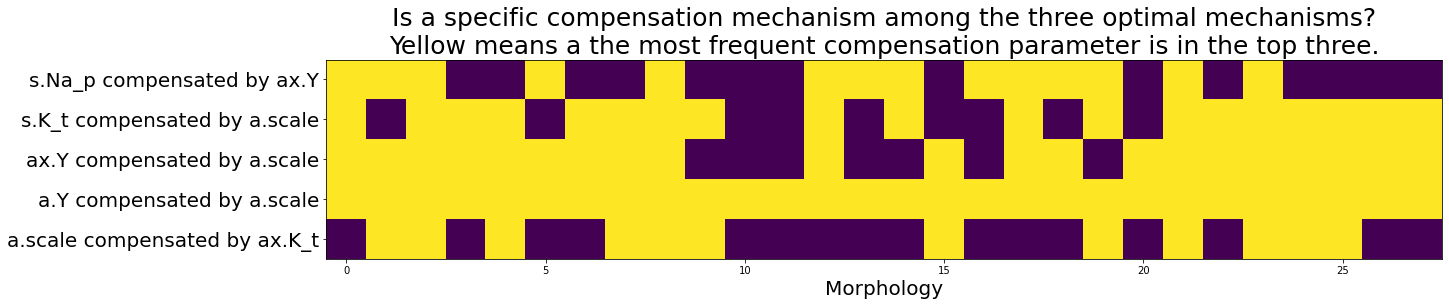

In [506]:
fig, ax = plt.subplots(1,1,figsize=(20, 4))
ax.imshow(valids)
ax.set_xlabel("Morphology", fontsize=20)
ax.set_yticks(np.arange(5))
ax.set_yticklabels(label_compensation, fontsize=20)
ax.set_title("Is a specific compensation mechanism among the three optimal mechanisms?\nYellow means a the most frequent compensation parameter is in the top three.", fontsize=25)
plt.savefig("list_of_compensations.png", dpi=200, bbox_inches="tight", facecolor='w')

In [423]:
min_fraction_of_best_parameter = np.argmax(min_2d_fraction, axis=1)
param_best_min = all_2d_fractions[:, :, min_fraction_of_best_parameter]

In [342]:
all_fracss = []
for morph in range(28):
    current = []
    for k in range(35):
        current.append(all_2d_fractions[morph, k, min_fraction_of_best_parameter[k]])
    current = np.asarray(current)
    all_fracss.append(current)
all_fracss= np.asarray(all_fracss)

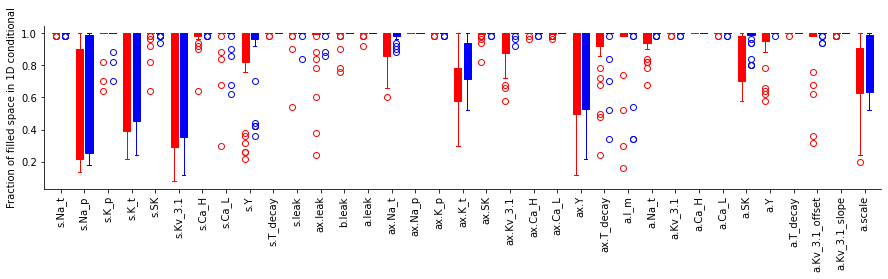

In [344]:
fig, ax = plt.subplots(1,1,figsize=(15,3))
c = 'r'
_ = ax.boxplot(all_1d_fractions, positions=np.arange(0, 35)-0.2, widths=0.3, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
)
c = 'b'
_ = ax.boxplot(all_fracss, positions=np.arange(0, 35)+0.2, widths=0.3, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xticks(np.arange(0,35))
_ = ax.set_xticklabels(names_, rotation=90)
ax.set_ylabel("Fraction of filled space in 1D conditional")
plt.savefig("fraction_of_filled_space_2d_conditional_min.png", dpi=200, bbox_inches="tight", facecolor='w')

### Normalize this hosgorma by the marginal width

In [507]:
def get_marginal_covered_fraction(str1, str2, str3):

    filepath = f"/home/michael/Documents/arco_sims/adaptive_box_posteriors2/{str1}_{str2}_{str3}.pickle"

    with open(filepath, "rb") as handle:
        posterior = pickle.load(handle)

    all_bounds_ = bounds.bounds_
    bounds_ = all_bounds_[str1, str2]
    upper_ = np.asarray(list(bounds_["max"].values()))
    lower_ = np.asarray(list(bounds_["min"].values()))
    gt_ = np.asarray(list(bounds_["value"].values()))
    limits = np.asarray([lower_, upper_]).T

    condition = torch.as_tensor(gt_, dtype=torch.float32)
    posterior.set_default_x(xo)

    limits_diffs = limits[:, 1] - limits[:, 0]
    eps_margins = limits_diffs / 1e5

    samples = posterior.sample((10000,))
    fraction_of_filled_space = []
    fig, ax = plt.subplots(1, 35, figsize=(30, 1))
    for i in range(35):
        hist_vals = ax[i].hist(samples[:, i].numpy(), bins=50, range=limits[i])
        hist_vals_bigger_zero = np.asarray(hist_vals[0]) > 0
        number_above_zero = np.sum(hist_vals_bigger_zero)
        fraction_of_filled_space.append(number_above_zero / len(hist_vals[0]))
        ax[i].set_xlim(limits[i])
        ax[i].set_yticks([])
        ax[i].set_xticks([])
        ax[i].set_xlabel(f"dim {i+1}")

    return fraction_of_filled_space

s ['84', '7712997831240842', '0.015']



s ['85', '1', '0.02']



s ['85', '5', '0.015']



s ['86', '6', '0.005']



s ['86', '707527054352652', '0.01']



s ['87', '550434680389613', '0.005']



s ['87', '73418029210004229', '0.005']



s ['88', '59997244694401254', '0.015']



s ['88', '86940691440007411', '0.01']



s ['88', '90233447606250669', '0.005']



s ['89', '1506562604769867', '0.02']



s ['89', '49992413252944133', '0.02']



s ['89', '98394633867104423', '0.025']



s ['91', '5', '0.03']



s ['91', '63065090307991878', '0.045']



s ['93', '49588549670578687', '0.01']



s ['WR64_Cell8_L5TT_constant_mean_max_dendscale_2.0', '94', '0.01']



s ['WR64_Cell8_L5TT_constant_mean_max_dendscale_2.0', '96', '0.01']



s ['WR64_Cell8_L5TT_constant_mean_max_dendscale_2.5', '81', '0.015']



s ['WR64_Cell8_L5TT_constant_mean_max_dendscale_2.5', '84', '0.03']



s ['WR69_Cell2_L5TT_mean', '1', '0.005']


<ipython-input-507-c29a3f9dd292>:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 35, figsize=(30, 1))


s ['WR69_Cell2_L5TT_mean', '32', '0.01']



s ['WR69_Cell2_L5TT_medfilt', '1', '0.005']



s ['WR69_Cell2_L5TT_medfilt', '6', '0.01']



s ['WR71_Cell6_L5TT_constant_mean', '104', '0.02']



s ['WR71_Cell6_L5TT_constant_mean', '120', '0.015']



s ['WR71_Cell6_L5TT_constant_mean_exclude_obliques_from_hot_zone', '130', '0.015']



s ['WR71_Cell6_L5TT_constant_mean_exclude_obliques_from_hot_zone', '136', '0.01']


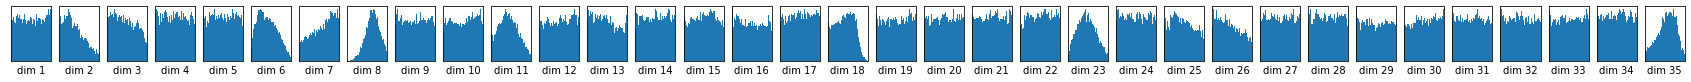

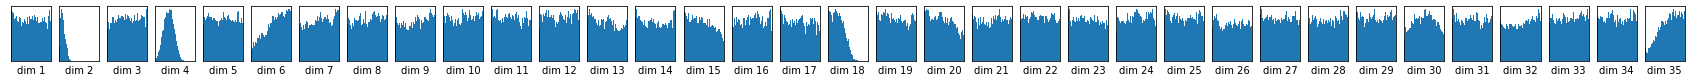

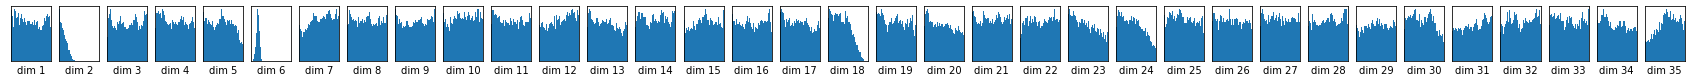

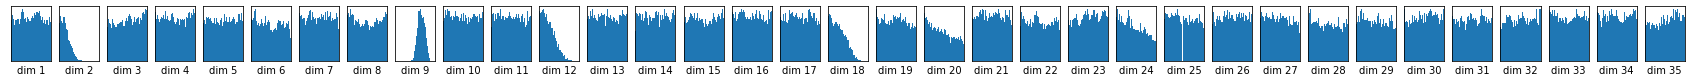

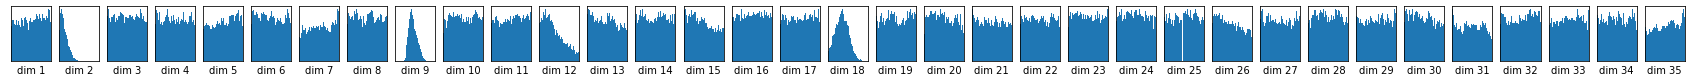

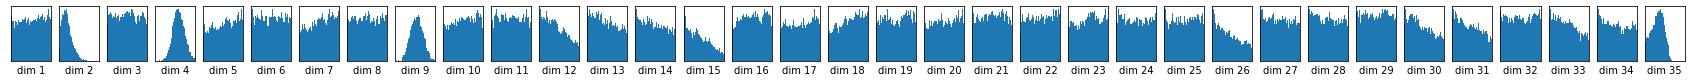

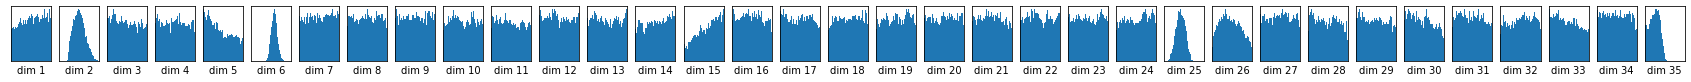

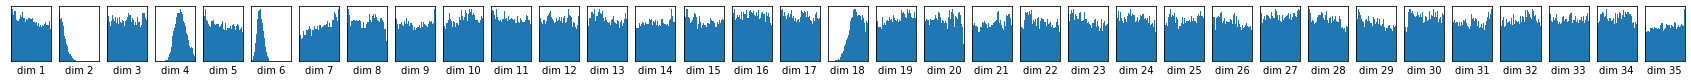

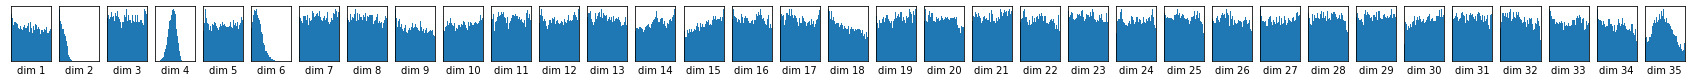

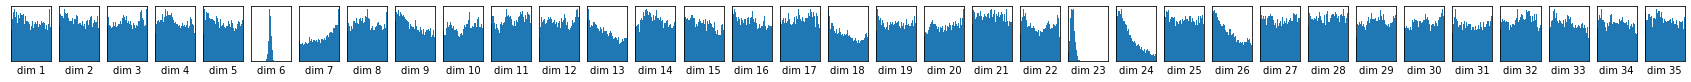

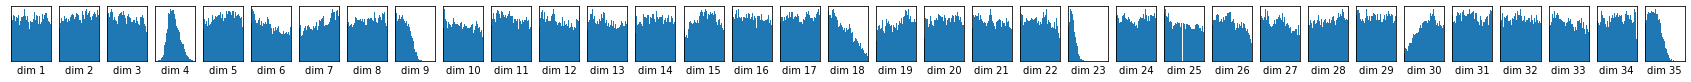

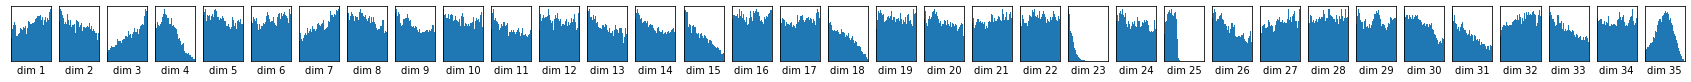

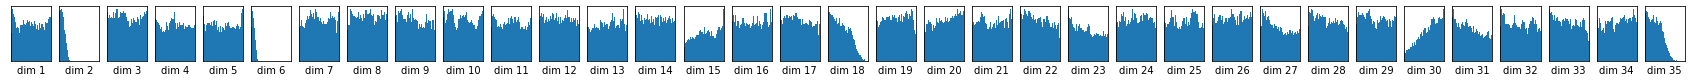

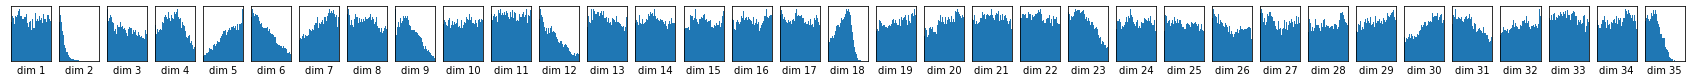

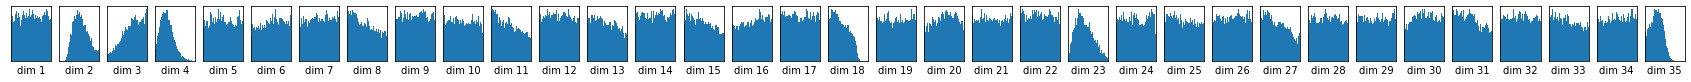

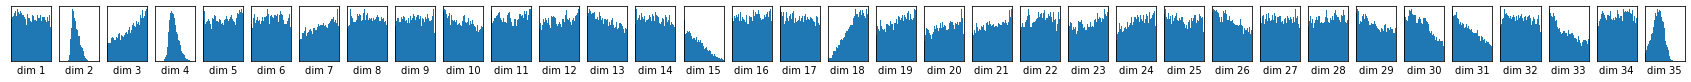

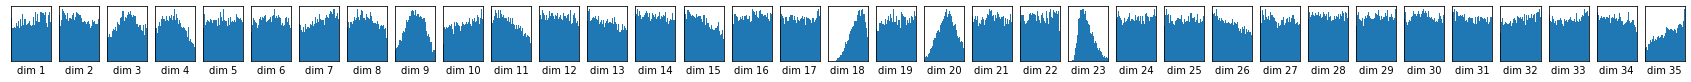

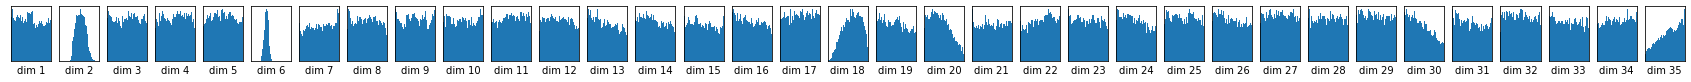

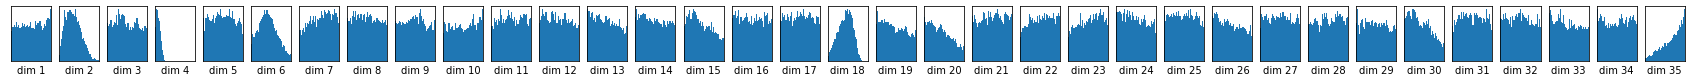

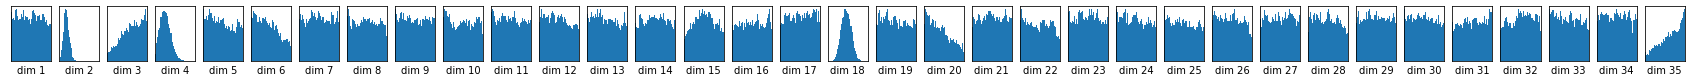

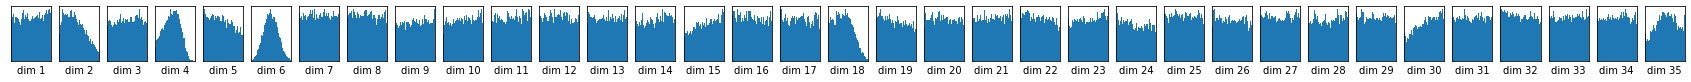

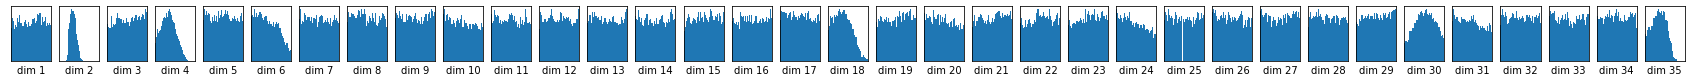

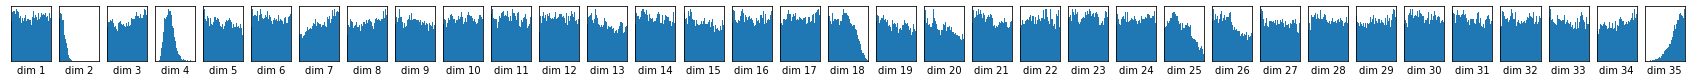

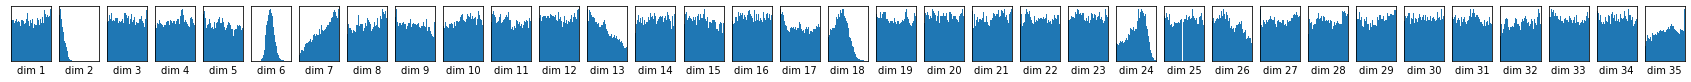

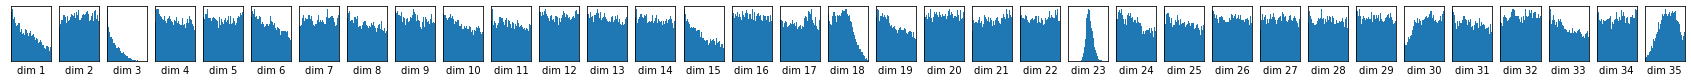

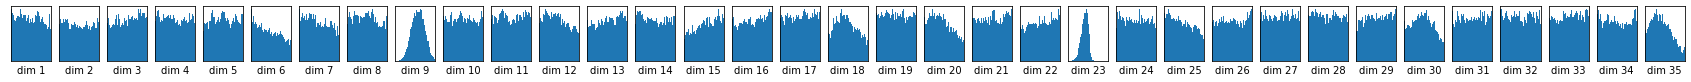

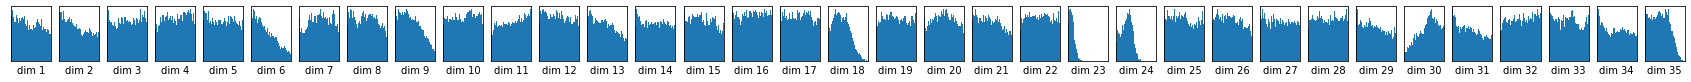

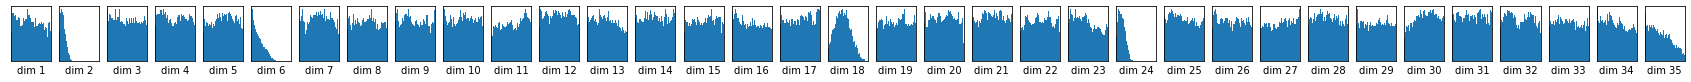

In [509]:
all_marginal_covs = []

for s in string_pairs:
    print("s", s)
    start_time = time.time()
    marginal_coverage_ = get_marginal_covered_fraction(*s)
    all_marginal_covs.append(marginal_coverage_)

all_marginal_covs = np.asarray(all_marginal_covs)
np.save("all_marginal_covs.npy", all_marginal_covs)

In [518]:
all_2d_fractions = np.load("all_2d_fractions.npy")
for i in range(28):
    for j in range(35):
        all_2d_fractions[i,j,:] /= all_marginal_covs[i,j]

In [519]:
min_2d_fraction = np.min(all_2d_fractions, axis=0)

In [520]:
min_fraction_of_best_parameter = np.argmax(min_2d_fraction, axis=1)
param_best_min = all_2d_fractions[:, :, min_fraction_of_best_parameter]

In [527]:
compensating_names = np.asarray(names_)[min_fraction_of_best_parameter]

In [536]:
label_names = [a+"   cb   "+b for a,b in zip(names_, compensating_names)]

In [537]:
all_fracss = []
for morph in range(28):
    current = []
    for k in range(35):
        current.append(all_2d_fractions[morph, k, min_fraction_of_best_parameter[k]])
    current = np.asarray(current)
    all_fracss.append(current)
all_fracss= np.asarray(all_fracss)

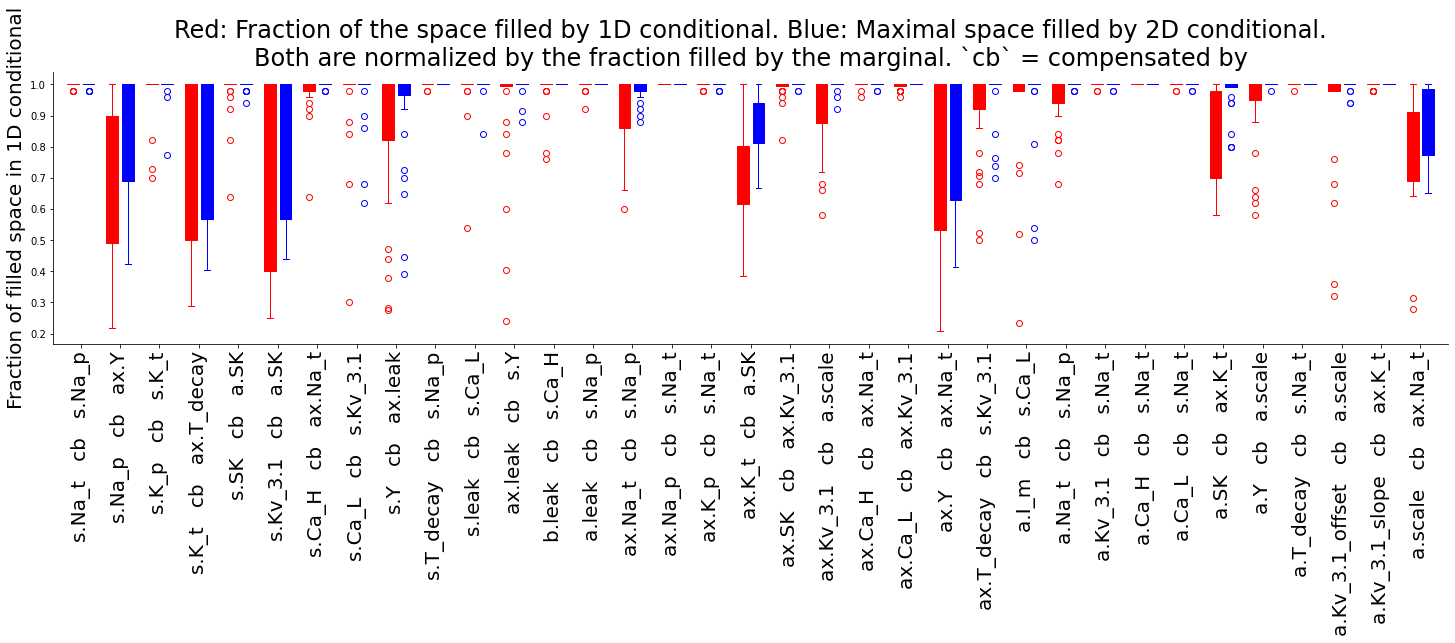

In [540]:
fig, ax = plt.subplots(1,1,figsize=(25, 5))
c = 'r'
_ = ax.boxplot(all_1d_fractions / all_marginal_covs, positions=np.arange(0, 35)-0.2, widths=0.3, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
)
c = 'b'
_ = ax.boxplot(all_fracss, positions=np.arange(0, 35)+0.2, widths=0.3, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xticks(np.arange(0,35))
_ = ax.set_xticklabels(label_names, rotation=90, fontsize=20)
ax.set_title("Red: Fraction of the space filled by 1D conditional. Blue: Maximal space filled by 2D conditional.\nBoth are normalized by the fraction filled by the marginal. `cb` = compensated by", fontsize=24)
ax.set_ylabel("Fraction of filled space in 1D conditional", fontsize=20)
plt.savefig("fraction_of_filled_space_2d_conditional_min_corrected_by_marginal.png", dpi=200, bbox_inches="tight", facecolor='w')